In [1]:
# basic bitches
import numpy as np
import pandas as pd
import datetime as dt
import missingno as msn

# preprocessing
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# model
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_curve, accuracy_score

# viz
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

% matplotlib inline

Using TensorFlow backend.


# Task 1

predictive_maintenance_dataset.csv is a file that contains parameters and settings: 
- operational_setting_1
- operational_setting_2
- sensor_measurement_1
- sensor_measurement_2
...            
for many wind turbines.        

There is a column called `unit_number` which specifies which turbine it is, and one called `status`, in which a value of 1 means the turbine broke down that day, and 0 means it didn't. 

Your task is to create a model that, when fed with operational settings and sensor measurements (unit_number and time_stamp will not be fed in), outputs 1 if the turbine will break down within the next 40 days, and 0 if not.

In [2]:
df = pd.read_csv("predictive_maintenance_dataset.csv")
df.shape

(144203, 27)

In [3]:
df.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,540,2017-02-19 12:00:00,0,42.0007,0.8415,High,445.00,NaN,1362.47,1143.17,...,133.75,2388.50,8129.92,9.1182,NaN,332.0,2212.0,100.00,10.77,6.5717
1,396,2017-11-21 12:00:00,0,-0.0023,0.0004,High,518.67,642.33,1581.03,1400.06,...,522.19,2388.00,8135.70,8.3817,0.03,393.0,2388.0,100.00,39.07,23.3958
2,513,2017-02-12 12:00:00,0,NaN,0.6216,Low,462.54,536.71,1250.87,1037.52,...,163.11,2028.06,7867.90,10.8827,NaN,306.0,1915.0,84.93,14.33,8.6202
3,211,2014-06-05 12:00:00,0,42.0006,NaN,High,NaN,549.28,1349.42,1114.02,...,130.58,2387.71,8074.81,9.3776,0.02,NaN,2212.0,100.00,10.60,6.2614
4,460,2014-11-27 12:00:00,0,-0.0016,0.0004,High,518.67,643.84,1604.53,1431.41,...,519.44,2388.24,8135.95,8.5223,0.03,396.0,2388.0,100.00,38.39,23.0682


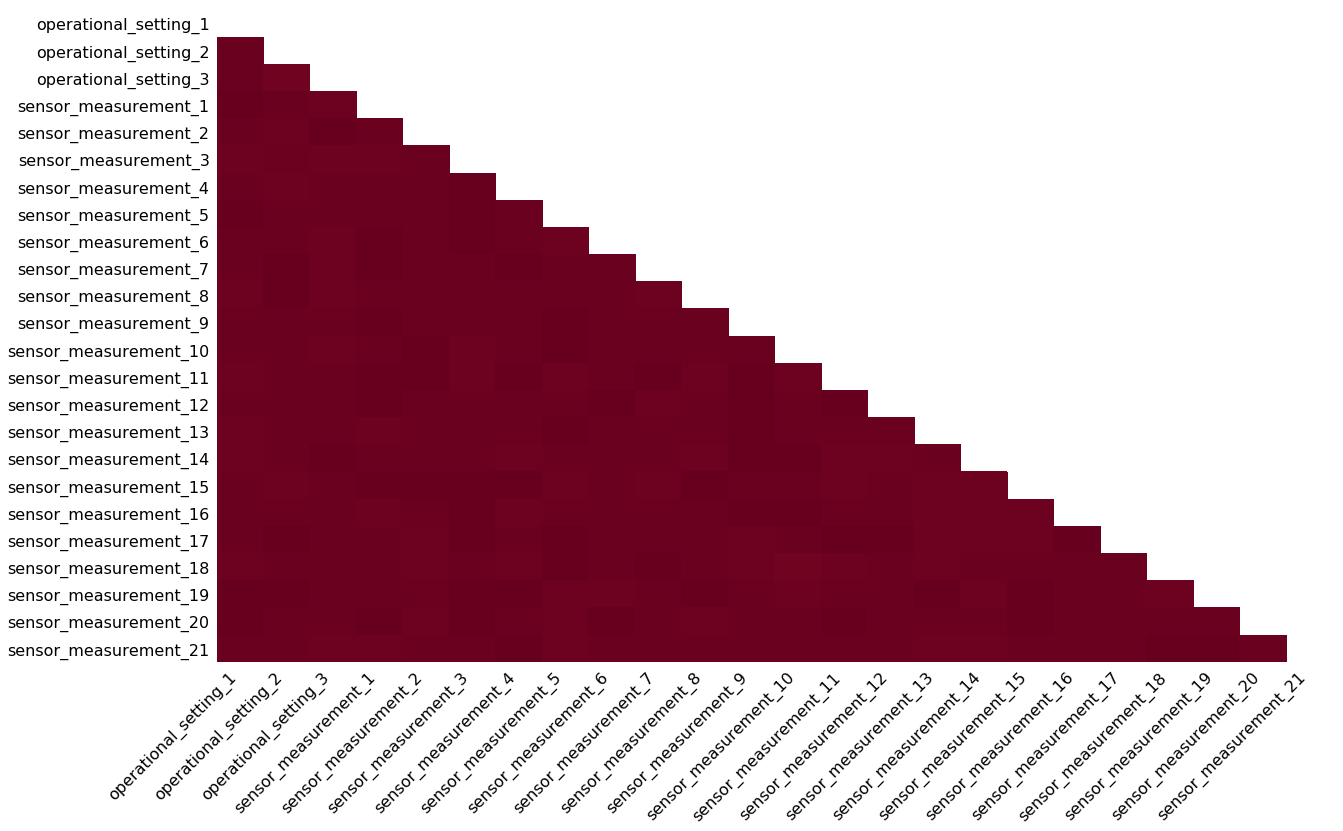

In [4]:
# Explore correlation
msn.heatmap(df)

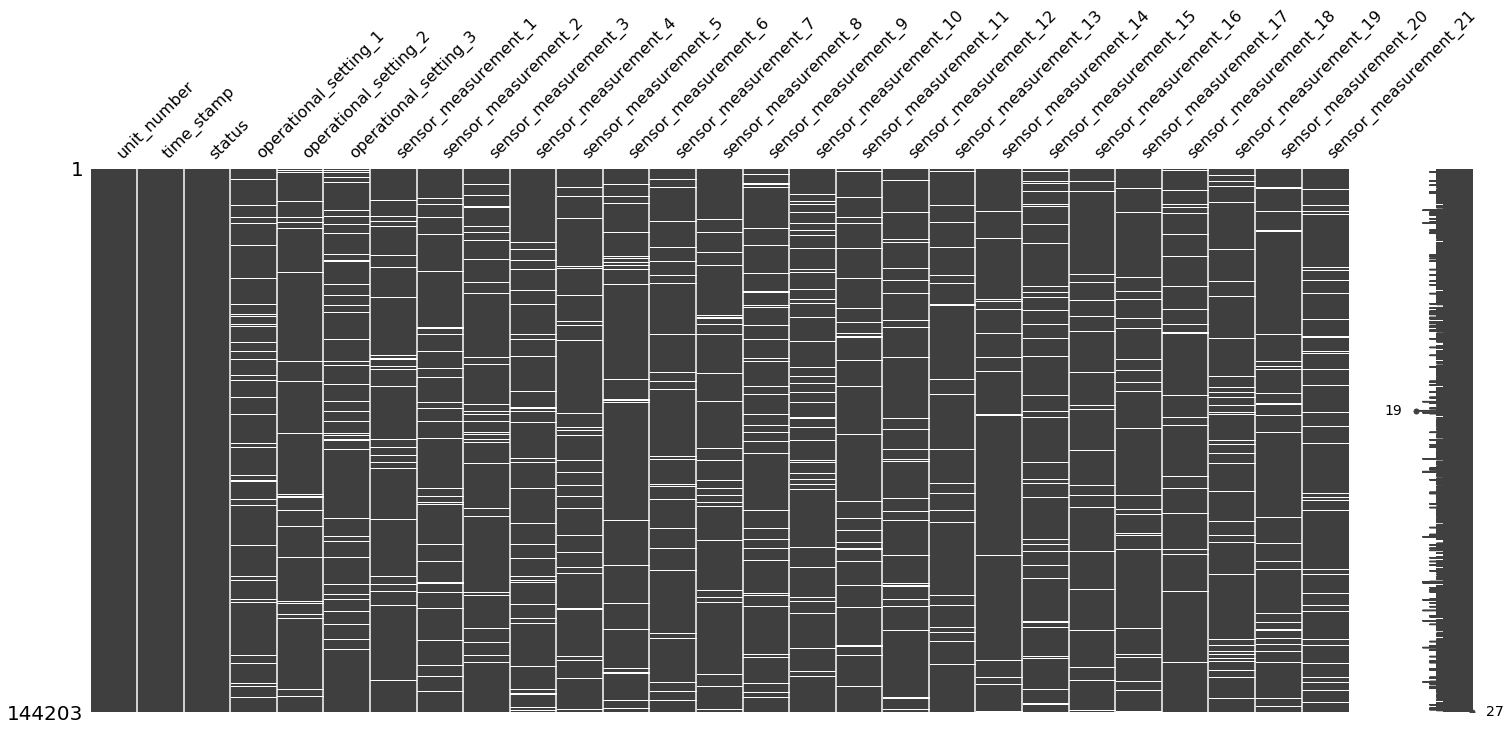

In [5]:
msn.matrix(df)

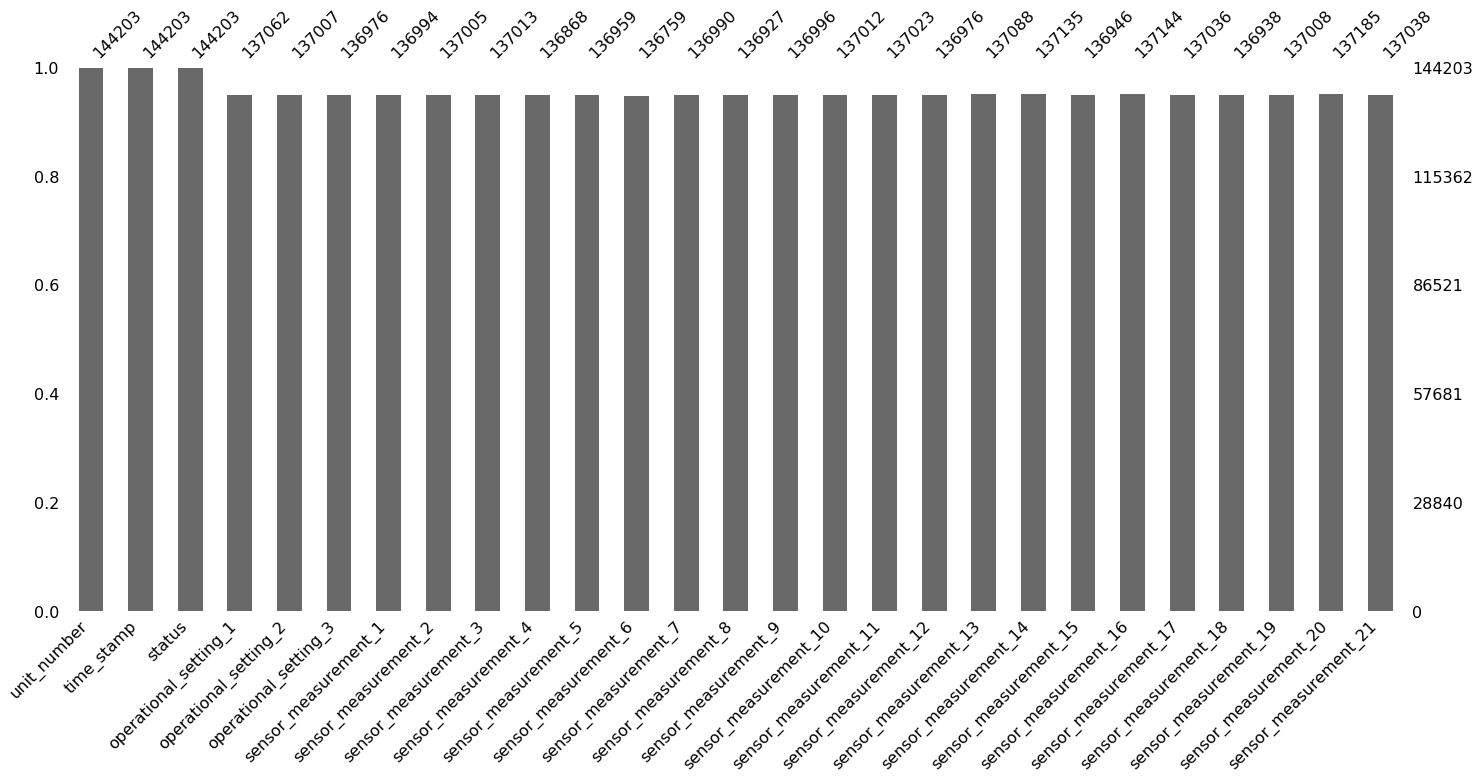

In [6]:
msn.bar(df)

In [7]:
df.iloc[:,3:28].describe()

,operational_setting_1,operational_setting_2,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
count,137062.000000,137007.000000,136994.000000,137005.000000,137013.000000,136868.000000,136959.000000,136759.000000,136990.000000,136927.000000,...,136976.000000,137088.000000,137135.000000,136946.000000,137144.000000,137036.000000,136938.000000,137008.000000,137185.000000,137038.000000
mean,17.075966,0.406348,486.132686,597.771761,1468.144709,1262.295400,9.935961,14.487827,361.227447,2274.757600,...,340.434790,2349.903834,8089.449809,9.049490,0.025226,360.999569,2274.604843,98.402123,26.050472,15.631200
std,16.534306,0.368293,30.435453,42.514419,118.189101,136.348238,4.268740,6.447176,174.309332,142.335384,...,164.371761,110.837314,80.528884,0.751212,0.004995,31.017661,142.432048,4.639714,11.703273,7.022004
min,-0.008700,-0.000600,445.000000,535.480000,1242.980000,1023.770000,3.910000,5.670000,136.170000,1914.720000,...,128.450000,2027.570000,7848.360000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.091800
25%,0.001200,0.000200,449.440000,549.990000,1357.620000,1127.060000,5.480000,8.000000,175.730000,2212.130000,...,164.820000,2387.970000,8070.750000,8.437700,0.020000,332.000000,2212.000000,100.000000,14.340000,8.604525
50%,10.007800,0.251900,491.190000,606.520000,1493.670000,1293.970000,10.520000,15.460000,392.840000,2323.690000,...,370.220000,2388.070000,8119.710000,8.741350,0.030000,368.000000,2324.000000,100.000000,28.250000,16.944950
75%,35.001300,0.840000,518.670000,642.350000,1586.720000,1402.300000,14.620000,21.610000,553.320000,2388.050000,...,521.370000,2388.160000,8139.630000,9.343700,0.030000,392.000000,2388.000000,100.000000,38.830000,23.299000
max,42.008000,0.842000,518.670000,645.110000,1616.910000,1441.160000,14.620000,21.610000,570.810000,2388.640000,...,537.490000,2390.490000,8293.720000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.890000,23.950500


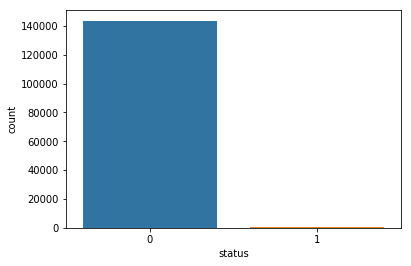

In [45]:
# Explore the status distribution
sns.countplot(x="status", data=df)

In [9]:
df["time"]=pd.to_datetime(df["time_stamp"]).dt.date

In [10]:
df.dtypes

unit_number                int64
time_stamp                object
status                     int64
operational_setting_1    float64
operational_setting_2    float64
operational_setting_3     object
sensor_measurement_1     float64
sensor_measurement_2     float64
sensor_measurement_3     float64
sensor_measurement_4     float64
sensor_measurement_5     float64
sensor_measurement_6     float64
sensor_measurement_7     float64
sensor_measurement_8     float64
sensor_measurement_9     float64
sensor_measurement_10    float64
sensor_measurement_11    float64
sensor_measurement_12    float64
sensor_measurement_13    float64
sensor_measurement_14    float64
sensor_measurement_15    float64
sensor_measurement_16    float64
sensor_measurement_17    float64
sensor_measurement_18    float64
sensor_measurement_19    float64
sensor_measurement_20    float64
sensor_measurement_21    float64
time                      object
dtype: object

In [11]:
df.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time
0,540,2017-02-19 12:00:00,0,42.0007,0.8415,High,445.00,NaN,1362.47,1143.17,...,2388.50,8129.92,9.1182,NaN,332.0,2212.0,100.00,10.77,6.5717,2017-02-19
1,396,2017-11-21 12:00:00,0,-0.0023,0.0004,High,518.67,642.33,1581.03,1400.06,...,2388.00,8135.70,8.3817,0.03,393.0,2388.0,100.00,39.07,23.3958,2017-11-21
2,513,2017-02-12 12:00:00,0,NaN,0.6216,Low,462.54,536.71,1250.87,1037.52,...,2028.06,7867.90,10.8827,NaN,306.0,1915.0,84.93,14.33,8.6202,2017-02-12
3,211,2014-06-05 12:00:00,0,42.0006,NaN,High,NaN,549.28,1349.42,1114.02,...,2387.71,8074.81,9.3776,0.02,NaN,2212.0,100.00,10.60,6.2614,2014-06-05
4,460,2014-11-27 12:00:00,0,-0.0016,0.0004,High,518.67,643.84,1604.53,1431.41,...,2388.24,8135.95,8.5223,0.03,396.0,2388.0,100.00,38.39,23.0682,2014-11-27


In [12]:
wind_turbin = df.sort_values("time")
wind_turbin.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time
2152,308,2014-01-01 12:00:00,0,41.9996,0.8400,High,445.00,548.98,1348.32,1115.01,...,2387.89,8078.93,9.3585,0.02,330.0,2212.0,100.0,10.64,6.2918,2014-01-01
68477,286,2014-01-01 12:00:00,0,20.0058,0.7008,NaN,491.19,606.98,1478.82,1246.69,...,2388.09,8068.06,NaN,0.02,365.0,2324.0,100.0,24.58,14.7213,2014-01-01
25338,22,2014-01-01 12:00:00,0,NaN,-0.0003,High,518.67,642.68,1595.65,1408.51,...,2388.16,8127.45,8.4425,0.03,393.0,2388.0,100.0,38.96,23.3081,2014-01-01
66476,122,2014-01-01 12:00:00,0,0.0002,0.0000,High,518.67,642.35,NaN,1396.41,...,2388.04,8136.80,8.3946,0.03,394.0,2388.0,NaN,39.04,NaN,2014-01-01
64572,360,2014-01-01 12:00:00,0,34.9989,NaN,High,449.44,NaN,1371.34,1121.46,...,2388.00,8064.58,9.2879,0.02,334.0,2223.0,100.0,14.88,8.9362,2014-01-01


In [13]:
wind_turbin["time_stamp"]=pd.to_datetime(wind_turbin["time_stamp"])
wind_turbin.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time
2152,308,2014-01-01 12:00:00,0,41.9996,0.8400,High,445.00,548.98,1348.32,1115.01,...,2387.89,8078.93,9.3585,0.02,330.0,2212.0,100.0,10.64,6.2918,2014-01-01
68477,286,2014-01-01 12:00:00,0,20.0058,0.7008,NaN,491.19,606.98,1478.82,1246.69,...,2388.09,8068.06,NaN,0.02,365.0,2324.0,100.0,24.58,14.7213,2014-01-01
25338,22,2014-01-01 12:00:00,0,NaN,-0.0003,High,518.67,642.68,1595.65,1408.51,...,2388.16,8127.45,8.4425,0.03,393.0,2388.0,100.0,38.96,23.3081,2014-01-01
66476,122,2014-01-01 12:00:00,0,0.0002,0.0000,High,518.67,642.35,NaN,1396.41,...,2388.04,8136.80,8.3946,0.03,394.0,2388.0,NaN,39.04,NaN,2014-01-01
64572,360,2014-01-01 12:00:00,0,34.9989,NaN,High,449.44,NaN,1371.34,1121.46,...,2388.00,8064.58,9.2879,0.02,334.0,2223.0,100.0,14.88,8.9362,2014-01-01


In [14]:
wind_turbin.tail(10)

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time
52886,548,2018-11-15 12:00:00,0,42.0044,0.8416,High,445.00,549.46,1361.26,1140.59,...,2388.61,8135.63,9.1333,0.02,333.0,2212.0,100.00,10.65,6.4800,2018-11-15
62173,624,2018-11-15 12:00:00,1,35.0031,0.8400,High,449.44,555.95,1382.71,1145.06,...,2388.94,8127.86,9.0359,0.02,338.0,2223.0,100.00,15.34,9.0906,2018-11-15
128075,548,2018-11-16 12:00:00,0,42.0026,0.8411,High,445.00,NaN,1366.22,1135.51,...,2388.58,8134.96,9.1462,0.02,333.0,2212.0,100.00,NaN,6.4746,2018-11-16
36346,548,2018-11-17 12:00:00,0,42.0042,0.8404,High,445.00,549.93,1357.67,1134.91,...,2388.62,8137.24,9.1298,0.02,333.0,2212.0,100.00,10.89,6.5528,2018-11-17
97745,548,2018-11-18 12:00:00,0,42.0063,0.8400,High,445.00,549.87,1366.48,1144.23,...,2388.63,8136.60,9.1202,0.02,334.0,2212.0,100.00,10.70,6.4323,2018-11-18
137110,548,2018-11-19 12:00:00,0,42.0004,0.8408,High,445.00,549.44,1364.55,1150.36,...,2388.61,8134.44,9.1069,0.02,335.0,2212.0,100.00,10.87,6.4370,2018-11-19
62467,548,2018-11-20 12:00:00,0,35.0078,0.8417,High,449.44,555.83,NaN,1146.32,...,2388.93,8121.22,9.0745,0.02,336.0,2223.0,100.00,15.05,9.0081,2018-11-20
11304,548,2018-11-21 12:00:00,0,25.0024,0.6217,Low,462.54,537.06,1271.60,1050.29,...,2028.79,7904.57,10.6433,0.02,310.0,1915.0,84.93,14.61,8.8109,2018-11-21
18265,548,2018-11-22 12:00:00,0,35.0019,NaN,High,449.44,555.82,1376.38,1154.62,...,2388.88,8125.40,9.0632,0.02,337.0,NaN,100.00,NaN,9.1576,2018-11-22
109893,548,2018-11-23 12:00:00,1,0.0024,0.0001,High,518.67,643.49,1601.91,1425.16,...,2388.59,8195.82,8.2052,0.03,399.0,2388.0,100.00,39.60,23.8068,2018-11-23


In [15]:
wind_turbin = wind_turbin.reset_index().iloc[:,1:29]

In [16]:
wind_turbin["total_date"] = wind_turbin.groupby("unit_number")['time_stamp'].transform(lambda g: g.iloc[-1] - g.iloc[0])

In [17]:
wind_turbin[["time_stamp","unit_number","total_date"]].head()

,time_stamp,unit_number,total_date
0,2014-01-01 12:00:00,308,149 days
1,2014-01-01 12:00:00,286,193 days
2,2014-01-01 12:00:00,22,201 days
3,2014-01-01 12:00:00,122,191 days
4,2014-01-01 12:00:00,360,315 days


Looking at the number of total date for all wind turbine. An average number is around 200 - 250 days for each wind turbine.

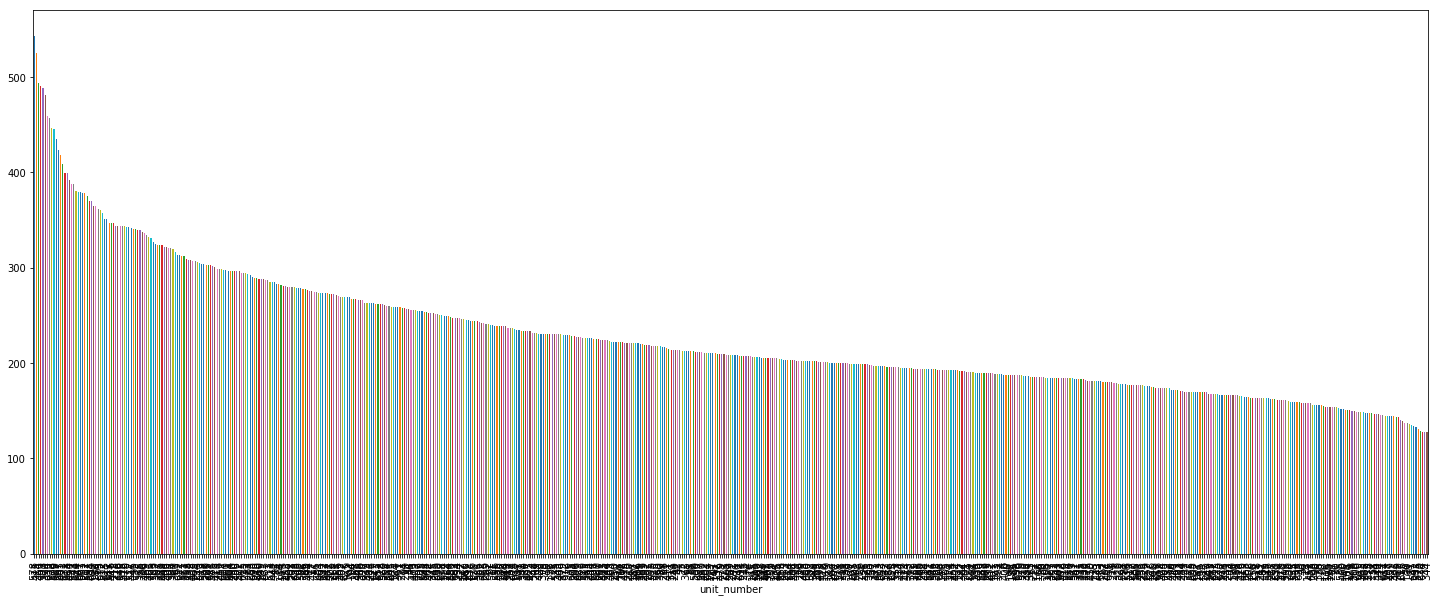

In [18]:
wind_turbin[["time_stamp","unit_number","total_date"]].groupby("unit_number").size().sort_values(ascending=False).plot.bar(figsize=(25, 10))

In [19]:
# Create label
wind_turbin['mark'] = 0
for i in range(1,41):
    wind_turbin["status_shift"] = wind_turbin.groupby("unit_number")['status'].transform(lambda g: g.shift(periods=-i))
    wind_turbin['mark'] = wind_turbin['mark'] + np.where(wind_turbin["status_shift"]==0.0, 0, 1)

wind_turbin['label'] = np.where(wind_turbin["mark"]==0.0, 0, 1)
# final_col = [ i for i in wind_turbin.columns if i not in ['mark', 'status_shift']]
# wind_turbin = wind_turbin[final_col]
wind_turbin[["time_stamp","unit_number","total_date","label"]].head()

,time_stamp,unit_number,total_date,label
0,2014-01-01 12:00:00,308,149 days,0
1,2014-01-01 12:00:00,286,193 days,0
2,2014-01-01 12:00:00,22,201 days,0
3,2014-01-01 12:00:00,122,191 days,0
4,2014-01-01 12:00:00,360,315 days,0


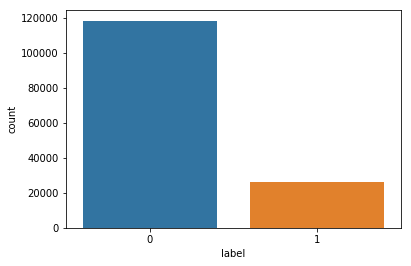

In [46]:
# Explore the label distribution
sns.countplot(x="label", data=wind_turbin)

In [20]:
wind_turbin.shape

(144203, 32)

In [21]:
wind_turbin["status_shift"].tail()

144198   NaN
144199   NaN
144200   NaN
144201   NaN
144202   NaN
Name: status_shift, dtype: float64

In [22]:
# Excluding the last 40 days of each unit
wind_turbine = wind_turbin.dropna(subset=['status_shift'])
wind_turbine.shape

(118883, 32)

In [23]:
# Drop all row that has missing value:
wind_turbine_drop = wind_turbine.dropna()
wind_turbine_drop.shape

(34678, 32)

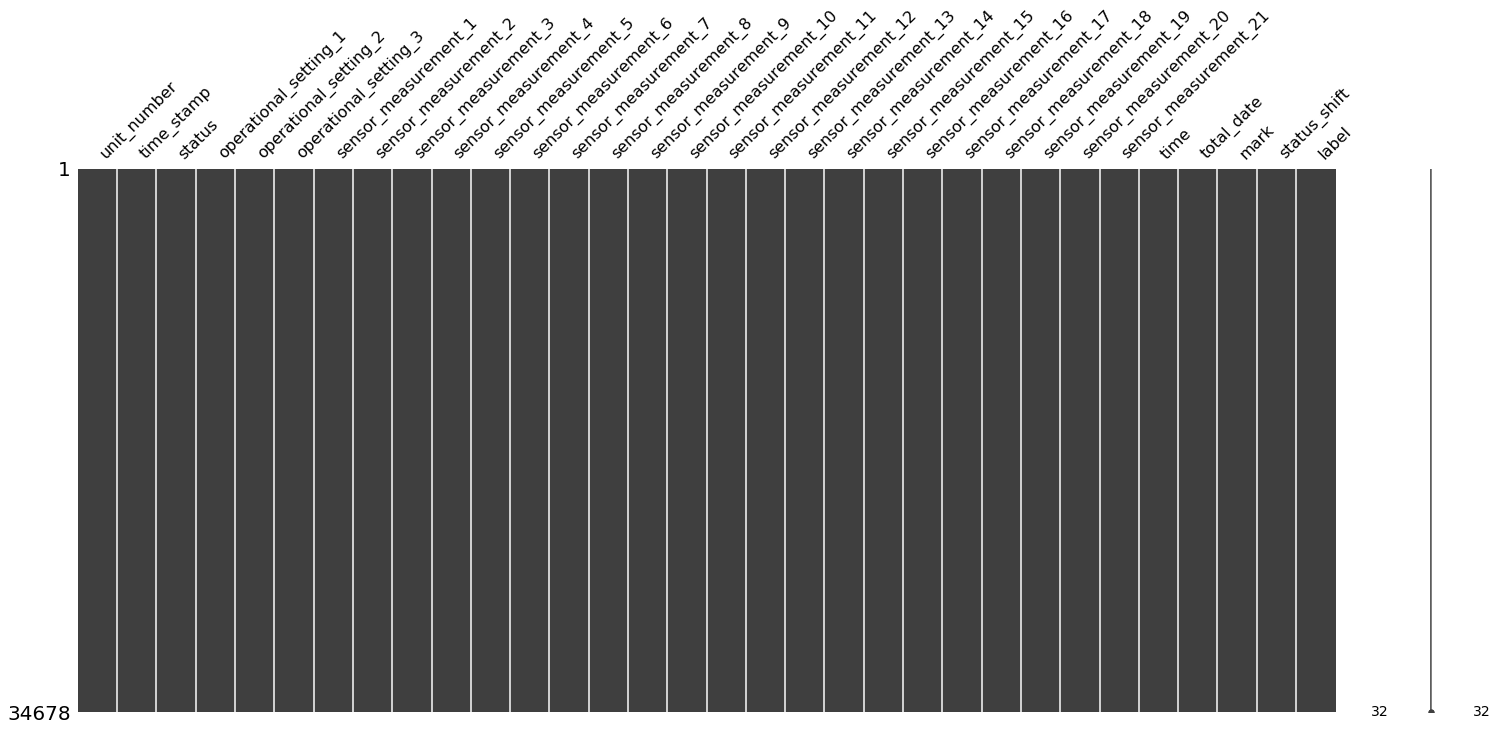

In [24]:
# Check if all NA has been removed:
msn.matrix(wind_turbine_drop)

In [25]:
wind_turbine[wind_turbine["label"]==1]

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time,total_date,mark,status_shift,label
3295,610,2014-04-19 12:00:00,0,42.0047,0.8400,High,445.00,549.80,1358.73,1129.46,...,329.0,2212.0,100.00,10.56,6.3727,2014-04-19,148 days,1,1.0,1
3378,308,2014-04-20 12:00:00,0,24.9985,0.6200,Low,462.54,537.00,1266.28,1058.60,...,308.0,1915.0,84.93,14.08,8.5807,2014-04-20,149 days,1,1.0,1
3401,129,2014-04-21 12:00:00,0,35.0059,0.8414,High,NaN,NaN,1364.95,NaN,...,334.0,2223.0,100.00,NaN,8.8954,2014-04-21,150 days,1,1.0,1
4503,287,2014-05-08 12:00:00,0,20.0013,0.7000,High,491.19,607.71,1491.85,1255.34,...,366.0,2324.0,100.00,24.40,14.5797,2014-05-08,167 days,1,1.0,1
5223,278,2014-05-19 12:00:00,0,35.0062,0.8400,High,449.44,555.57,1368.99,1127.79,...,335.0,NaN,100.00,14.84,8.9077,2014-05-19,147 days,1,1.0,1
5578,162,2014-05-24 12:00:00,0,0.0029,0.0005,High,518.67,643.77,1595.31,1416.13,...,395.0,2388.0,100.00,38.68,23.2098,2014-05-24,183 days,1,1.0,1
6074,122,2014-06-01 12:00:00,0,42.0031,0.8400,High,NaN,550.10,1353.37,1133.28,...,331.0,2212.0,100.00,10.67,6.2729,2014-06-01,191 days,1,1.0,1
6248,286,2014-06-03 12:00:00,0,0.0019,0.0018,High,518.67,642.55,1594.55,1411.85,...,396.0,2388.0,100.00,38.61,23.3212,2014-06-03,193 days,1,1.0,1
6687,157,2014-06-08 12:00:00,0,41.9995,0.8400,High,445.00,549.67,1358.05,1127.79,...,330.0,2212.0,100.00,10.58,6.3241,2014-06-08,139 days,1,1.0,1
6804,12,2014-06-10 12:00:00,0,0.0001,0.0001,High,518.67,642.42,1590.42,1427.28,...,395.0,2388.0,100.00,NaN,23.2302,2014-06-10,169 days,1,1.0,1


Seems like an unbalanced data set. There are 633 obs has label 1.

In [26]:
wind_turbine.groupby("unit_number").count().head()

,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time,total_date,mark,status_shift,label
unit_number,,,,,,,,,,,,,,,,,,,,,
2,247,247,238,233,241,237,231,240,235,228,...,235,233,239,235,233,247,247,247,247,247
3,139,139,136,131,137,133,129,135,130,133,...,131,129,134,134,133,139,139,139,139,139
4,149,149,139,143,140,140,141,140,141,139,...,139,145,145,144,146,149,149,149,149,149
5,229,229,216,216,211,218,217,217,219,218,...,218,218,222,219,218,229,229,229,229,229
6,148,148,144,139,142,142,140,138,139,139,...,143,139,140,140,138,148,148,148,148,148


In [27]:
X_col = [ i for i in wind_turbine.columns if i not in ['unit_number', 'time', 'total_date', 'status',
                                                       'label', 'mark', 'status_shift']]

In [28]:
# Create X, y
X = wind_turbine_drop[X_col]
y = wind_turbine_drop[["label","time_stamp"]]

In [29]:
X["operational_setting_3"].describe()

count     34678
unique        2
top        High
freq      31017
Name: operational_setting_3, dtype: object

In [30]:
X["operational_setting_3"] = pd.get_dummies(X["operational_setting_3"]).iloc[:,0]

c:\intelpython3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
# Split Train, Test, Validation set

# For X
Xval = X[X['time_stamp'].dt.year==2018].loc[:, X.columns != "time_stamp"]
Xtest = X[(X['time_stamp'].dt.year < 2018) & (X['time_stamp'].dt.year > 2015)].loc[:,X.columns != "time_stamp"]
Xtrain = X[X['time_stamp'].dt.year<2016].loc[:,X.columns != "time_stamp"]

# For y:
yval = y[y['time_stamp'].dt.year==2018]['label']
ytest = y[(y['time_stamp'].dt.year < 2018) & (y['time_stamp'].dt.year > 2015)]['label']
ytrain = y[y['time_stamp'].dt.year<2016]['label']

In [32]:
Xtrain.head()

,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
6,10.0029,0.2511,1,489.05,604.73,1496.59,1305.02,10.52,15.49,395.29,...,372.20,2388.01,8135.48,8.6057,0.03,366.0,2319.0,100.00,28.74,17.1307
8,25.0071,0.6200,0,462.54,537.00,1257.79,1046.50,7.05,9.03,175.33,...,164.28,2028.34,7880.20,10.8643,0.02,305.0,1915.0,84.93,14.25,8.6234
13,41.9991,0.8416,1,445.00,548.88,1351.14,1123.82,3.91,5.71,138.92,...,130.47,2387.84,8081.67,9.3457,0.02,329.0,2212.0,100.00,10.67,6.3425
15,24.9981,0.6216,0,462.54,536.88,1264.02,1054.22,7.05,9.03,176.15,...,164.30,2028.08,7870.69,10.9144,0.02,308.0,1915.0,84.93,14.31,8.5945
17,19.9987,0.7012,1,491.19,607.08,1481.04,1243.92,9.35,13.65,334.84,...,315.28,2388.10,8066.41,9.1915,0.02,364.0,2324.0,100.00,24.49,14.7063


In [33]:
Xtrain.columns == Xtest.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [34]:
Xtrain.columns == Xval.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [35]:
# Upsizing the data:
sm = SMOTE(random_state=42)
Xtrain_res, ytrain_res = sm.fit_sample(Xtrain, ytrain)

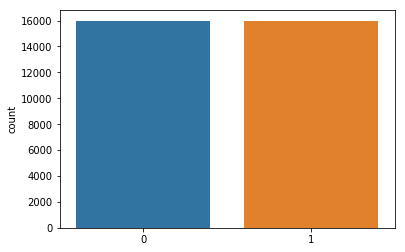

In [38]:
# new distribution of labels:
sns.countplot(x=ytrain_res)

Fitting Logistic Regression model...
Train accuracy is: 0.892
Test accuracy is: 0.835
Confusion Maxtric for Logistic Regression model


c:\intelpython3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


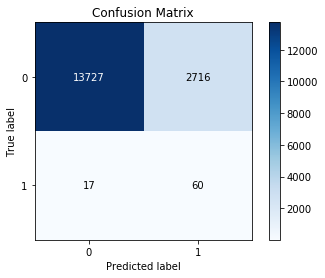

Fitting Random Forest Classifier model...
Train accuracy is: 1.0
Test accuracy is: 0.993
Confusion Maxtric for Random Forest Classifier model


c:\intelpython3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


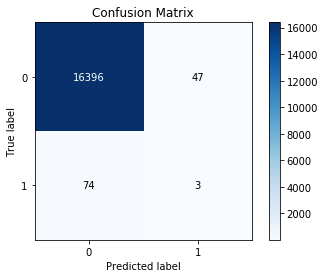

Fitting K Nearest Neighbor model...
Train accuracy is: 0.971
Test accuracy is: 0.911
Confusion Maxtric for K Nearest Neighbor model


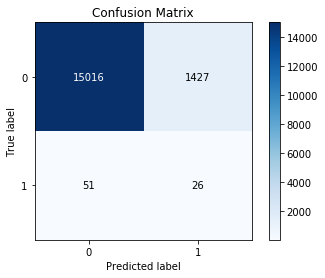

In [48]:
# Fitting general models:
model_list = {"Logistic Regression": LR(),
              "Random Forest Classifier": RFC(),
              "K Nearest Neighbor": KNN()
             }

for k, v in model_list.items():
    print("Fitting {} model...".format(k))
    v.fit(Xtrain_res, ytrain_res)
    print("Train accuracy is:", accuracy_score(ytrain_res, v.predict(Xtrain_res)).round(3))
    ypred = v.predict(Xtest)
    print("Test accuracy is:", accuracy_score(ytest, ypred).round(3))
    print("Confusion Maxtric for {} model".format(k))
    skplt.metrics.plot_confusion_matrix(ytest, ypred)
    plt.show()

In [ ]:
import xgboost as xgb

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(n_estimators=10, objective='binary:logistic', seed=123)

# Fit the classifier to the training set
xg_cl.fit(Xtrain, ytrain)

# Predict the labels of the test set: preds
preds = xg_cl.predict(Xtest)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==ytest))/ytest.shape[0]
print("accuracy: %f" % (accuracy))

In [ ]:
# pipeline
pl = Pipeline([
        ('Impute', Imputer()),
        ('clf', RandomForestClassifier(n_estimators=15))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)